<a href="https://colab.research.google.com/github/21Ovi/SkimLit/blob/main/SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit 📃🔥

The purpose of this notebook is to build an NLP model to make reading medical abstract easier.

The paper we're replicating ( THe source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to a GPU

In [1]:
!nvidia-smi

Mon Sep 18 16:24:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b1d604be-b0fd-aa41-dd45-0316083cbb7f)


## Get data

Since we'll be replicating the paper above (PubMed200K RCT), let's download the dataset they used

We can do so from the aurthors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Cgeck what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20K dataset with numbers replaced by "@" sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads file (a text filename) and return the lines of text as a list.

  Args:
    filename: a tring containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represnted...

```[{
    'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity',
    'total_lines': 11
  },...]```

In [10]:
# def preprocess_text_with_line_numbers(filename):
#   """
#   Returns a list of dictornaries of abstract line data.

#   Takes in filename, reads it content and sorts through each line,
#   extracting things like the target label, the text of the sentence,
#   how many sentences are in the current abstract and what sentence
#   number the target line is.
#   """
#   input_lines = get_lines(filename) # get all lines from filename
#   abstract_lines = "" # create an empty abstract
#   abstract_samples = [] # create an empty list of abstracts

#   # Loop through each line in the target file
#   for line in input_lines:
#     if line.startswith("###"): # Check to see if the line is an ID line
#       abstract_id = line
#       abstract_lines = "" # # reset the abstract string ig the line is an ID line
#     elif line.isspace(): # check to see if line is a new line
#       abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

#       # Iterate trhough each line in a single abstract and count them at the same time
#       for abstract_line_number, abstract_line in enumerate(abstract_line_split):
#         line_data = {} # create an empty dictornary for each line
#         target_text_split = abstract_line.split("\t") # splut target label from text
#         line_data["target"] = target_text_split[0] # get target label
#         line_data["text"] = target_text_split[1].lower() # get target text and lower it
#         line_data["line_number"] = abstract_line_number # what number does the line appear in the abstract
#         line_data["total_line"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
#         abstract_samples.append(line_data) # add line data to abstract samples list

#     else: #if the above conditions aren't fulfilled, line contains a labelled sentence
#       abstract_line += line
#   return abstract_samples

In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in a filename, reads its content, and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract, and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)  # get all lines from filename
  abstract_lines = ""  # create an empty abstract
  abstract_samples = []  # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):  # Check to see if the line is an ID line
      abstract_id = line
      abstract_lines = ""  # reset the abstract string if the line is an ID line
    elif line.isspace():  # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()  # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}  # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t")  # split target label from text
        line_data["target"] = target_text_split[0]  # get the target label
        line_data["text"] = target_text_split[1].lower()  # get the target text and lower it
        line_data["line_number"] = abstract_line_number  # what number does the line appear in the abstract
        line_data["total_line"] = len(abstract_line_split) - 1  # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data)  # add line data to abstract samples list

      # Reset abstract_lines after processing an abstract
      abstract_lines = ""
    else:  # if the above conditions aren't fulfilled, the line contains a labeled sentence
      abstract_lines += line  # concatenate the line to the current abstract lines
  return abstract_samples


In [12]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 744 ms, sys: 103 ms, total: 847 ms
Wall time: 1.08 s


(180040, 30212, 30135)

In [13]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontario an

Now that our data is in the format of a list of dictonarities, how about we turn it into a DataFrame to further visualize?

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

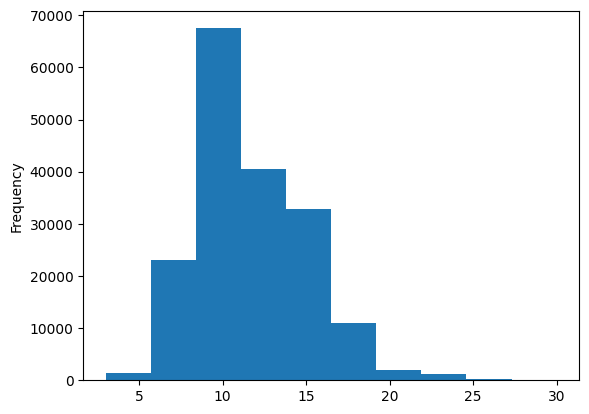

In [16]:
# Let's check the length of different lines
train_df.total_line.plot.hist();

### Get list of sentences

In [17]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View 10 lines of trainin sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check how one code encoded labels looks like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [20]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training label look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes Classifier).

## Model 0: Getting a baseline

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

# Download helper function script


In [25]:
!wget https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py

--2023-09-18 16:25:34--  https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10116 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.88K  --.-KB/s    in 0s      

2023-09-18 16:25:35 (84.3 MB/s) - ‘helper_functions.py’ saved [10116/10116]



In [26]:
from helper_functions import calculate_results

In [27]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building depper models, we've got to create vectorization and embedding layers.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [29]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

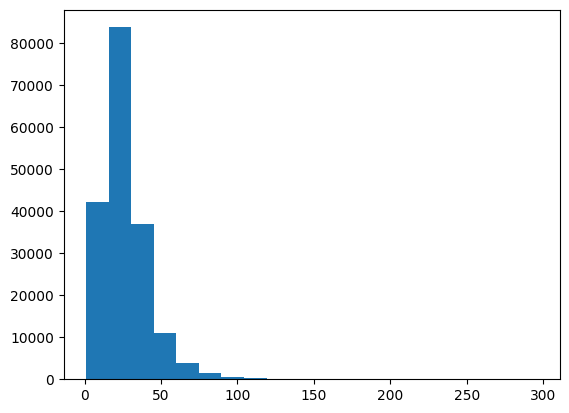

In [30]:
# What's the distribution look like?
plt.hist(sent_lens, bins=20);

In [31]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our text from words to numbers.

In [33]:
# How many words in our vocabulary? (from docs)
max_tokens = 68000

In [34]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of word in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length pf vectorized sequences

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text: \n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text: 
this study compared the effects of nitroprusside and remifentanil on hemodynamics using a noninvasive cardiac output monitor ( cheetah nicom ( ) ; cheetah medical inc. , maidenhead , berkshire , uk ) for endoscopic sinus surgery ( ess ) .

Length of text:41

Vectorized text: [[   23    17    34     2    71     4 13123     3  1442    18  3750    59
      8  1903   342  1894  2477 40336 51308 40336   274  3601 53147 40788
   1404    11  1304  1773   115  5845     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:10]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # lenght of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name="token_embedding")

In [40]:
# Shoe example embedding
print(f"Sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding) : \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}\n")

Sentence before vectorization: 
 this study compared the effects of nitroprusside and remifentanil on hemodynamics using a noninvasive cardiac output monitor ( cheetah nicom ( ) ; cheetah medical inc. , maidenhead , berkshire , uk ) for endoscopic sinus surgery ( ess ) .

Sentence after vectorization (before embedding) : 
 [[   23    17    34     2    71     4 13123     3  1442    18  3750    59
      8  1903   342  1894  2477 40336 51308 40336   274  3601 53147 40788
   1404    11  1304  1773   115  5845     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding: 
 [[[-0.02704841 -0.01880417  0.00892697 ... -0.04471259  0.04755432
    0.04873859]
  [-0.00105237  0.00435028 -0.01569869 ...  0.00666869  0.04410851
    0.02697023]
  [ 0.04425979 -0.01678803  0.02810348 ...  0.0083334   0.04649976
    0.00446689]
  ...
  [-0.04720766  0.00583601  0.03632164 ...  0.035

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data



In [41]:
# Turn our data into TensorFLow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the TensorSlizeDataset's and turn them into
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [43]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [44]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [46]:
# Fit the model
history_model_1 =  model_1.fit(train_dataset,
                               steps_per_epoch=int(0.1 * len(train_dataset)),
                               epochs=3,
                               validation_data=valid_dataset,
                               validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 46s 64ms/step - loss: 0.9072 - accuracy: 0.6444 - val_loss: 0.6773 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.6540 - accuracy: 0.7596 - val_loss: 0.6241 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6152 - accuracy: 0.7756 - val_loss: 0.5951 - val_accuracy: 0.7839


In [47]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5968 - accuracy: 0.7863


[0.5968484282493591, 0.7863431572914124]

In [48]:
# Make prediction (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 3ms/step


(array([[4.3933693e-01, 1.6571034e-01, 8.6029470e-02, 2.8331625e-01,
         2.5607070e-02],
        [4.3970096e-01, 2.7105010e-01, 1.4110283e-02, 2.6644766e-01,
         8.6909225e-03],
        [1.3551167e-01, 6.9270032e-03, 1.7059465e-03, 8.5582280e-01,
         3.2655065e-05],
        ...,
        [5.5887199e-06, 7.8551448e-04, 7.4848061e-04, 3.6357337e-06,
         9.9845684e-01],
        [5.0481342e-02, 4.9489111e-01, 1.0019835e-01, 7.0103578e-02,
         2.8432563e-01],
        [1.7434496e-01, 6.8619382e-01, 3.1434894e-02, 3.8924422e-02,
         6.9101833e-02]], dtype=float32),
 (30212, 5))

In [49]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.63431748973917,
 'precision': 0.7833619852537996,
 'recall': 0.7863431748973918,
 'f1': 0.7839228958050927}

In [51]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction wit pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically Univarsal Sentence Encoder (USE) :

https://tfhub.dev/google/universal-sentence-encoder/4

The paper orignallu use GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings

In [52]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [53]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: \n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: \n {len(use_embedded_sentence[0])}")

Random sentence: 
 to examine upper limb physical function and adverse effects after axillary lymph node dissection ( alnd ) and sentinel lymph node biopsy ( slnb ) in patients with breast cancer to identify impairments that can inform rehabilitation strategies .
Sentence after embedding: 
 [-0.05479873  0.01618159 -0.04602926 -0.07006362  0.03347746 -0.0747802
  0.01621798 -0.0335989  -0.06057469 -0.02700689  0.07542282  0.01729791
 -0.02152972 -0.02557485  0.04487102  0.01641983 -0.07542191  0.01439376
  0.0006432  -0.04218503  0.01367032  0.07175779 -0.0534806   0.01494329
 -0.04527281  0.03771936 -0.0573029  -0.05787602  0.01045397  0.06876823]

Length of sentence embedding: 
 512


## Building and fitting an NLP Feature Extraction model using pretrained embeddings from TensorFlow Hub

In [54]:
# Define feature extraction model using TF Hub Layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: we can add more layers here
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_2_USE_feature_extractor")

In [55]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
# get the summary of model
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [57]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 15ms/step - loss: 0.9214 - accuracy: 0.6472 - val_loss: 0.7976 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7702 - accuracy: 0.7021 - val_loss: 0.7549 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7532 - accuracy: 0.7121 - val_loss: 0.7400 - val_accuracy: 0.7114


In [58]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7414 - accuracy: 0.7135


[0.7414267063140869, 0.713458240032196]

In [59]:
# Make predictions with the feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 12ms/step


array([[0.4592343 , 0.3671523 , 0.00219009, 0.16434613, 0.00707724],
       [0.3313222 , 0.52426517, 0.0038698 , 0.13773605, 0.00280672],
       [0.24443986, 0.15974538, 0.01605767, 0.5403831 , 0.03937403],
       ...,
       [0.00193019, 0.00666288, 0.04911248, 0.0009664 , 0.94132805],
       [0.00349733, 0.05778297, 0.23441835, 0.00144267, 0.7028587 ],
       [0.19062035, 0.26293984, 0.48294666, 0.00713113, 0.05636208]],
      dtype=float32)

In [60]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [61]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.34582285184695,
 'precision': 0.7132449505159317,
 'recall': 0.7134582285184695,
 'f1': 0.7102394743973274}

In [62]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

the paper which we're replicating states thet used a combination of token and character level of embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.


### Creating a character-level tokenizer

In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [64]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't o   e x a m i n e   u p p e r   l i m b   p h y s i c a l   f u n c t i o n   a n d   a d v e r s e   e f f e c t s   a f t e r   a x i l l a r y   l y m p h   n o d e   d i s s e c t i o n   (   a l n d   )   a n d   s e n t i n e l   l y m p h   n o d e   b i o p s y   (   s l n b   )   i n   p a t i e n t s   w i t h   b r e a s t   c a n c e r   t o   i d e n t i f y   i m p a i r m e n t s   t h a t   c a n   i n f o r m   r e h a b i l i t a t i o n   s t r a t e g i e s   .'

In [65]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_cahr_len = np.mean(char_lens)
mean_cahr_len

149.3662574983337

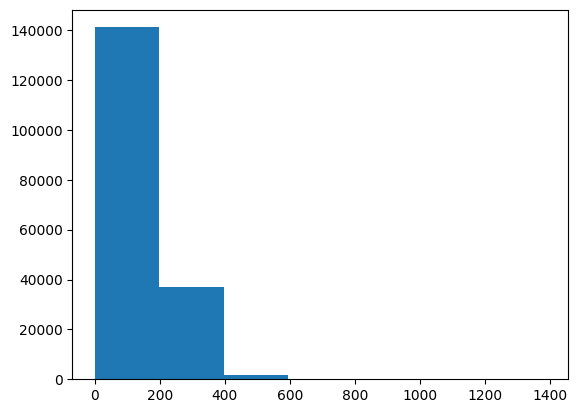

In [67]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [68]:
# Find what character length covsers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = Out Of Vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    # standardize=None, # if you want to leave punctuation in
                                    name="char_vectorizer")

In [71]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 Most common characters: {char_vocab[:5]}")
print(f"5 Most least characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 Most common characters: ['', '[UNK]', 'e', 't', 'i']
5 Most least characters: ['k', 'x', 'z', 'q', 'j']


In [73]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized_chars: {len(vectorized_chars[0])}")

Charified text:
 a f t e r   p r e p l a n n e d   a d j u s t m e n t   f o r   c h a n g e s   i n   c i   i n   c a s e   o f   a   d e l i v e r y - d e p e n d e n t   s t a t e   i n   s o m e   p a t i e n t s   (   w i t h   e x c l u s i o n   o f   o n e   a d d i t i o n a l   p a t i e n t   b e c a u s e   o f   m i s s i n g   c i   d a t a   )   ,   t h i s   b e c a m e   s t a t i s t i c a l l y   s i g n i f i c a n t   (   @   m l / m i n   ,   s e   @   ;   p   =   @   )   .

Length of random_train_chars: 197

Vectorized chars:
 [[ 5 17  3  2  8 14  8  2 14 12  5  6  6  2 10  5 10 27 16  9  3 15  2  6
   3 17  7  8 11 13  5  6 18  2  9  4  6 11  4  4  6 11  5  9  2  7 17  5
  10  2 12  4 21  2  8 19 10  2 14  2  6 10  2  6  3  9  3  5  3  2  4  6
   9  7 15  2 14  5  3  4  2  6  3  9 20  4  3 13  2 24 11 12 16  9  4  7
   6  7 17  7  6  2  5 10 10  4  3  4  7  6  5 12 14  5  3  4  2  6  3 22
   2 11  5 16  9  2  7 17 15  4  9  9  4  6 18 11  4 10  5  3  5  3 13  4


 ## Creating a character-level embedding

In [74]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper
                              mask_zero=True,
                              name="char_embed")

In [75]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding): \n {char_embed_example} \n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 a f t e r   p r e p l a n n e d   a d j u s t m e n t   f o r   c h a n g e s   i n   c i   i n   c a s e   o f   a   d e l i v e r y - d e p e n d e n t   s t a t e   i n   s o m e   p a t i e n t s   (   w i t h   e x c l u s i o n   o f   o n e   a d d i t i o n a l   p a t i e n t   b e c a u s e   o f   m i s s i n g   c i   d a t a   )   ,   t h i s   b e c a m e   s t a t i s t i c a l l y   s i g n i f i c a n t   (   @   m l / m i n   ,   s e   @   ;   p   =   @   )   .

Embedded chars. (after vectorization and embedding): 
 [[[-1.21114254e-02 -2.06015594e-02 -1.11428015e-02 ... -2.31782924e-02
    3.42907645e-02  4.62186597e-02]
  [ 7.21238926e-03 -4.71230634e-02  3.15471739e-03 ... -9.80868936e-05
   -2.30056047e-03 -1.35354884e-02]
  [-4.07834277e-02  2.15136148e-02 -1.54844150e-02 ...  4.54925187e-02
   -1.68268196e-02  5.83782047e-03]
  ...
  [-6.87866285e-03 -4.96784113e-02 -2.38946080e-02 ... -4.90499847e-02
    3.38258035e-02  2.49025486e-02]
  [-6.878

## Building a Conv1D model to fit on character embeddings

In [76]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

In [77]:
# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [78]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [79]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [80]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2465 - accuracy: 0.5024 - val_loss: 1.0355 - val_accuracy: 0.5914
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.9985 - accuracy: 0.5988 - val_loss: 0.9465 - val_accuracy: 0.6273
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9196 - accuracy: 0.6350 - val_loss: 0.8730 - val_accuracy: 0.6602


In [81]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.14841804, 0.40791526, 0.03963979, 0.36982718, 0.03419972],
       [0.24874216, 0.5958171 , 0.01084527, 0.11786816, 0.02672732],
       [0.24358803, 0.39103848, 0.06105573, 0.29353905, 0.01077867],
       ...,
       [0.01664675, 0.03482151, 0.28777993, 0.02896378, 0.631788  ],
       [0.02820128, 0.17223474, 0.3366257 , 0.05469742, 0.40824088],
       [0.4655226 , 0.3802832 , 0.04849895, 0.09343746, 0.01225772]],
      dtype=float32)

In [82]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [83]:
# Calculate results for Conv1D model chars
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.68913014696147,
 'precision': 0.6480445156125586,
 'recall': 0.6568913014696147,
 'f1': 0.6455584001524731}

In [84]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layers)

1. Create a token-level embedding model (similar to `modal_1`)
2. Create a character-level model (similar to `model_3` with slight modification)
3. Combine 1 & 2 with a cicatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure ` and sectopm 4.2 of paper
5. Construct a model which takes token and character-level sequence as input and prodices sequence label probabilities as output

In [85]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [86]:
# 2. Create a character-level inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [87]:
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

In [88]:
# Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combine_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combine_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [89]:
# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [90]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

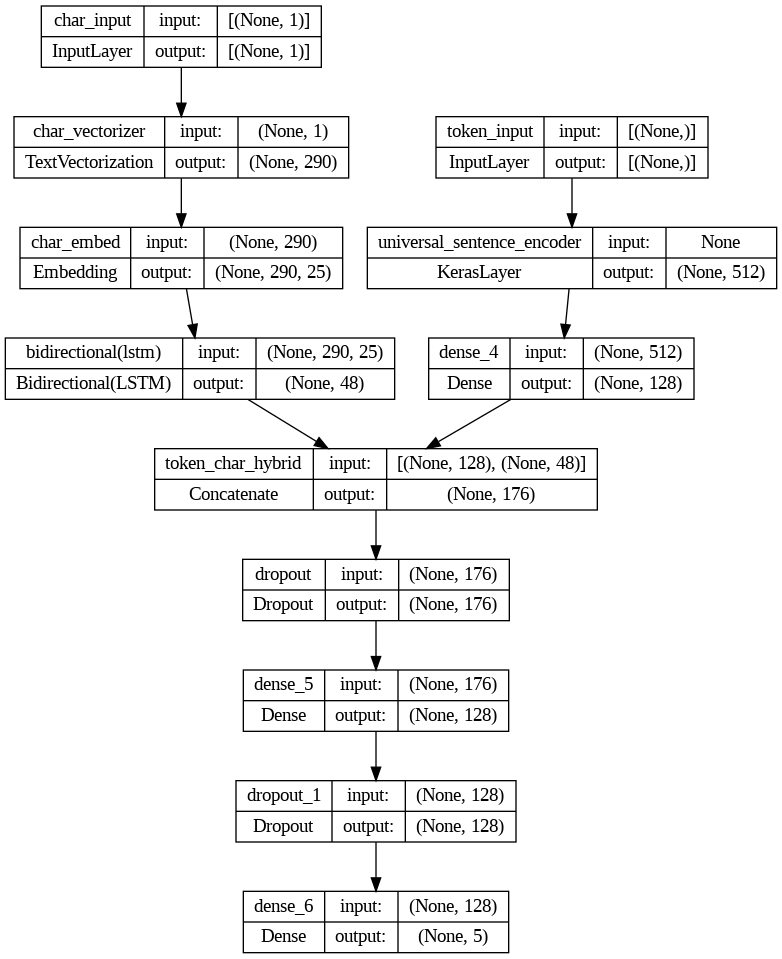

In [91]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [92]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character into tf.data Dataset

In [93]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
# Combine chars and tokens into a dataset for validation
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch validation data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting the model on token and character-leve sequences

In [96]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 45s 60ms/step - loss: 0.9915 - accuracy: 0.6045 - val_loss: 0.7823 - val_accuracy: 0.6965
Epoch 2/3
562/562 [==============================] - 30s 54ms/step - loss: 0.7994 - accuracy: 0.6945 - val_loss: 0.7225 - val_accuracy: 0.7237
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7810 - accuracy: 0.7037 - val_loss: 0.6923 - val_accuracy: 0.7424


In [97]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 23ms/step - loss: 0.6995 - accuracy: 0.7341


[0.6995083689689636, 0.7341122627258301]

In [98]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 22ms/step


array([[4.4372648e-01, 3.4512603e-01, 3.2058679e-03, 2.0122607e-01,
        6.7154639e-03],
       [2.8739983e-01, 5.5034912e-01, 1.9254546e-03, 1.5853898e-01,
        1.7866136e-03],
       [2.7886659e-01, 1.7767479e-01, 5.1878788e-02, 4.5431241e-01,
        3.7267428e-02],
       ...,
       [7.9807412e-04, 9.0274634e-03, 6.8202153e-02, 4.7142114e-04,
        9.2150092e-01],
       [5.2601639e-03, 7.3241532e-02, 1.8282376e-01, 2.7813332e-03,
        7.3589313e-01],
       [2.6295498e-01, 3.6685666e-01, 2.5729239e-01, 3.3024065e-02,
        7.9871923e-02]], dtype=float32)

In [99]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [102]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.41122732688999,
 'precision': 0.7357693223586314,
 'recall': 0.7341122732688998,
 'f1': 0.7320412976725335}

## Model 5: Transfer Learning with Pretrained token embedding + character embedding + positional embedding

In [103]:
train_df.head()

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note:** Any engineered features used to train a model need to be avaialbe at test time. In our case, line number and total lines are available.

### Create positional embeddings

In [105]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

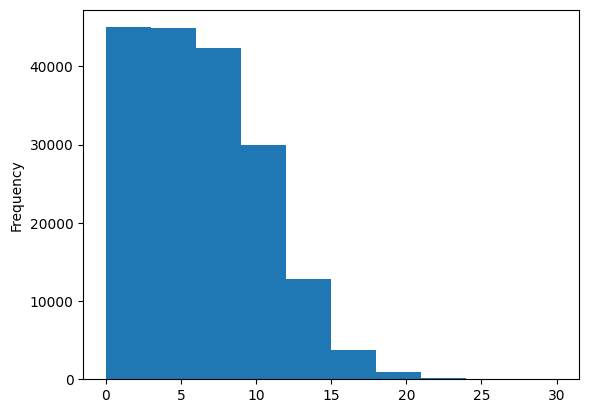

In [106]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [111]:
# Use tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_number_one_hot[:14], train_line_number_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.